In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import ParameterGrid
import pysindy as ps
import os
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from torch.fft import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import MultiTaskLassoCV, LinearRegression
from sklearn.feature_selection import SelectFromModel
from typing import Tuple, Any, Iterable, Dict
from sklearn.model_selection import train_test_split

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
#for Lorenz Data2
train_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data2\train_lorenz_subset.npy"
test_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data2\test_lorenz_subset.npy"
val_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data2\validate_lorenz_subset.npy"
train_data = np.load(train_file_path)
test_data = np.load(test_file_path)
val_data = np.load(val_file_path)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", val_data.shape)

Train data shape: (700, 100, 3)
Test data shape: (150, 100, 3)
Validation data shape: (150, 100, 3)


In [5]:
#for Lorenz Data1
train_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data1\lorenz_train.npy"
test_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data1\lorenz_test.npy"
val_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data1\lorenz_val.npy"
train_data = np.load(train_file_path)
test_data = np.load(test_file_path)
val_data = np.load(val_file_path)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", val_data.shape)

Train data shape: (16000, 100, 3)
Test data shape: (2000, 100, 3)
Validation data shape: (2000, 100, 3)


In [6]:
batch_size = 64

def prepare_dataloader(data, batch_size):
    inputs = torch.tensor(data[:, :-1, :], dtype=torch.float32)  # All but last timestep as input
    targets = torch.tensor(data[:, -1, :], dtype=torch.float32)  # Last timestep as target
    dataset = TensorDataset(inputs, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = prepare_dataloader(train_data, batch_size)
val_loader = prepare_dataloader(val_data, batch_size)
test_loader = prepare_dataloader(test_data, batch_size)

In [7]:
class AdvancedConvFNO(nn.Module):
    def __init__(self, modes, width, conv_filters):
        super(AdvancedConvFNO, self).__init__()
        self.modes = modes
        self.width = width

        # Convolutional Layers
        self.conv1 = nn.Conv1d(3, conv_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(conv_filters, conv_filters, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(conv_filters, self.width, kernel_size=3, padding=1)

        # Fourier Neural Operator
        self.fc0 = nn.Linear(self.width, self.width)
        self.fc1 = nn.Linear(self.width, self.width)
        self.fc2 = nn.Linear(self.width, 3)  # Output (x, y, z)

    def forward(self, x):
        batchsize, seq_len, channels = x.shape

        # Apply convolutions
        x = x.permute(0, 2, 1)  # Change to (batch, channels, seq_len)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.permute(0, 2, 1)  # Back to (batch, seq_len, channels)

        # Fourier Neural Operator
        x = self.fc0(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x[:, -1, :])  # Use the last timestep
        return x

In [8]:
# Define SINDy for Post-Training Analysis
def apply_sindy(train_data_flat, test_data_flat, dt):
    x_train = train_data_flat[:-1]
    dx_train = (train_data_flat[1:] - train_data_flat[:-1]) / dt
    x_test = test_data_flat[:-1]
    dx_test = (test_data_flat[1:] - test_data_flat[:-1]) / dt

    # Define the SINDy model
    feature_library = ps.PolynomialLibrary(degree=3)
    optimizer = ps.STLSQ(threshold=0.1)
    sindy_model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)

    # Fit and evaluate
    sindy_model.fit(x_train, t=dt, x_dot=dx_train)
    print("\nSINDy Discovered Equations:")
    sindy_model.print()
    print(f"SINDy Test Score: {sindy_model.score(x_test, t=dt, x_dot=dx_test):.4f}")

# Accuracy Calculation
def calculate_accuracy(outputs, targets, tolerance=0.1):
    correct = torch.sum(torch.abs(outputs - targets) < tolerance).item()
    total = targets.numel()
    return correct / total * 100


In [9]:
# Training Loop with Accuracy
def train_and_evaluate(model, train_loader, val_loader, epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += torch.sum(torch.abs(outputs - targets) < 0.1).item()
            train_total += targets.numel()

        train_accuracy = train_correct / train_total * 100

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_correct += torch.sum(torch.abs(outputs - targets) < 0.1).item()
                val_total += targets.numel()

        val_accuracy = val_correct / val_total * 100

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    return val_loss / len(val_loader)

In [10]:
# Hyperparameter Grid
param_grid = {
    'modes': [16, 32],
    'width': [64, 128],
    'conv_filters': [16, 32],
    'learning_rate': [0.001, 0.0005],
    'epochs': [50]
}

best_model = None
best_loss = float('inf')
best_params = None

# Grid Search for Hyperparameters
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    model = AdvancedConvFNO(modes=params['modes'], width=params['width'], conv_filters=params['conv_filters'])
    val_loss = train_and_evaluate(model, train_loader, val_loader,
                                  epochs=params['epochs'],
                                  learning_rate=params['learning_rate'])
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_params = params

print(f"Best Params: {best_params}, Best Validation Loss: {best_loss:.4f}")


Testing params: {'conv_filters': 16, 'epochs': 50, 'learning_rate': 0.001, 'modes': 16, 'width': 64}
Epoch 1/50, Train Loss: 24.1149, Train Accuracy: 10.27%, Val Loss: 0.5658, Val Accuracy: 20.77%
Epoch 2/50, Train Loss: 0.1482, Train Accuracy: 33.62%, Val Loss: 0.0676, Val Accuracy: 43.95%
Epoch 3/50, Train Loss: 0.0561, Train Accuracy: 47.30%, Val Loss: 0.0358, Val Accuracy: 55.88%
Epoch 4/50, Train Loss: 0.0421, Train Accuracy: 50.15%, Val Loss: 0.0338, Val Accuracy: 55.62%
Epoch 5/50, Train Loss: 0.0346, Train Accuracy: 52.52%, Val Loss: 0.0262, Val Accuracy: 56.85%
Epoch 6/50, Train Loss: 0.0309, Train Accuracy: 53.91%, Val Loss: 0.0260, Val Accuracy: 60.70%
Epoch 7/50, Train Loss: 0.0264, Train Accuracy: 57.28%, Val Loss: 0.0278, Val Accuracy: 59.18%
Epoch 8/50, Train Loss: 0.0233, Train Accuracy: 60.22%, Val Loss: 0.0317, Val Accuracy: 46.30%
Epoch 9/50, Train Loss: 0.0265, Train Accuracy: 58.32%, Val Loss: 0.0478, Val Accuracy: 30.62%
Epoch 10/50, Train Loss: 0.0205, Train Accu

In [11]:
def advanced_sindy(train_data_flat, test_data_flat, dt):
    x_train = train_data_flat[:-1]
    dx_train = (train_data_flat[1:] - train_data_flat[:-1]) / dt
    x_test = test_data_flat[:-1]
    dx_test = (test_data_flat[1:] - test_data_flat[:-1]) / dt

    # Define multiple libraries to test
    polynomial_degrees = [2, 3, 4]
    thresholds = [0.05, 0.1, 0.2]

    best_model = None
    best_score = -float("inf")
    best_params = {}

    for degree in polynomial_degrees:
        for threshold in thresholds:
            print(f"Testing SINDy with Polynomial Degree: {degree}, Threshold: {threshold}")

            # Define the SINDy model
            feature_library = ps.PolynomialLibrary(degree=degree) + ps.FourierLibrary(n_frequencies=3)
            optimizer = ps.STLSQ(threshold=threshold)
            sindy_model = ps.SINDy(
                optimizer=optimizer,
                feature_library=feature_library,
                differentiation_method=ps.FiniteDifference()
            )

            # Fit the model
            sindy_model.fit(x_train, t=dt, x_dot=dx_train)
            score = sindy_model.score(x_test, t=dt, x_dot=dx_test)

            if score > best_score:
                best_model = sindy_model
                best_score = score
                best_params = {"degree": degree, "threshold": threshold}

    # Print the best model's equations
    print("\nBest SINDy Model:")
    best_model.print()
    print(f"Best SINDy Test Score: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")

    # Evaluate on the test set
    test_score = best_model.score(x_test, t=dt, x_dot=dx_test)
    print(f"Final SINDy Test Score: {test_score:.4f}")

    return best_model, best_params, test_score

#need to apply in another way

# Apply SINDy
train_data_flat = train_data.reshape(-1, train_data.shape[-1])  # Flatten training data
test_data_flat = test_data.reshape(-1, test_data.shape[-1])  # Flatten test data
best_sindy_model, best_params, test_score = advanced_sindy(train_data_flat, test_data_flat, dt=0.01)

Testing SINDy with Polynomial Degree: 2, Threshold: 0.05
Testing SINDy with Polynomial Degree: 2, Threshold: 0.1
Testing SINDy with Polynomial Degree: 2, Threshold: 0.2
Testing SINDy with Polynomial Degree: 3, Threshold: 0.05
Testing SINDy with Polynomial Degree: 3, Threshold: 0.1
Testing SINDy with Polynomial Degree: 3, Threshold: 0.2
Testing SINDy with Polynomial Degree: 4, Threshold: 0.05
Testing SINDy with Polynomial Degree: 4, Threshold: 0.1
Testing SINDy with Polynomial Degree: 4, Threshold: 0.2

Best SINDy Model:
(x0)' = 0.051 1 + -10.517 x0 + 9.884 x1 + -0.699 sin(1 x0) + 1.586 sin(1 x1) + 0.243 cos(1 x1) + 0.390 sin(1 x2) + -0.060 sin(2 x0) + -0.092 cos(2 x0) + -0.237 sin(2 x1) + 0.287 cos(2 x1) + 0.323 sin(2 x2) + 0.052 cos(2 x2) + -0.300 cos(3 x0) + 0.496 sin(3 x1) + -0.441 cos(3 x1) + -0.227 sin(3 x2)
(x1)' = 0.109 1 + 26.422 x0 + -1.016 x1 + -0.977 x0 x2 + 1.548 sin(1 x1) + 0.296 cos(1 x1) + -0.192 sin(1 x2) + -0.326 cos(1 x2) + -0.090 sin(2 x0) + -0.306 cos(2 x0) + -0.261

In [12]:
def plot_predictions_vs_ground_truth(model, sindy_model, test_data, dt, device):
    # Prepare data for visualization
    test_inputs = torch.tensor(test_data[:, :-1, :], dtype=torch.float32).to(device)
    ground_truth = test_data[:, -1, :]

    # Model predictions
    model.eval()
    with torch.no_grad():
        model_predictions = model(test_inputs).cpu().numpy()

    # SINDy predictions
    test_data_flat = test_data.reshape(-1, test_data.shape[-1])
    sindy_inputs = test_data_flat[:-1]
    sindy_predictions = sindy_model.predict(sindy_inputs)

    # Visualize ground truth, model predictions, and SINDy predictions
    fig = plt.figure(figsize=(18, 6))

    # Ground Truth
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2], 'g', label="Ground Truth")
    ax1.set_title("Ground Truth")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.legend()

    # Model Predictions
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(model_predictions[:, 0], model_predictions[:, 1], model_predictions[:, 2], 'b', label="Model Predictions")
    ax2.set_title("Model Predictions")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax2.legend()

    # SINDy Predictions
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(sindy_predictions[:, 0], sindy_predictions[:, 1], sindy_predictions[:, 2], 'r', label="SINDy Predictions")
    ax3.set_title("SINDy Predictions")
    ax3.set_xlabel("X")
    ax3.set_ylabel("Y")
    ax3.set_zlabel("Z")
    ax3.legend()

    plt.tight_layout()
    plt.show()

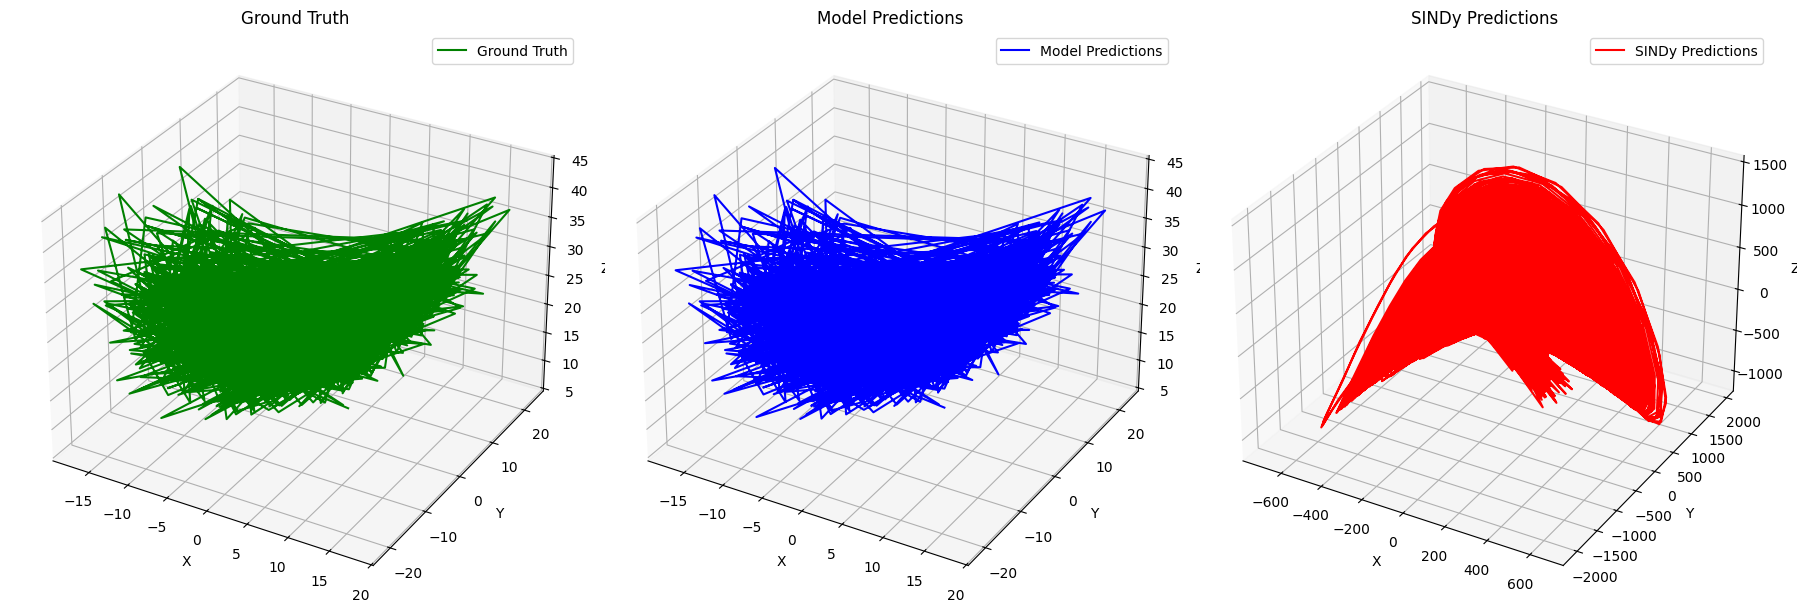

In [13]:
# Visualize predictions vs ground truth in 3D
plot_predictions_vs_ground_truth(best_model, best_sindy_model, test_data, dt=0.01, device=device)